# Import packages

In [269]:
%pip install -q pandas matplotlib numpy scikit-learn ace_tools panelsplit shap upgrade jupyter ipywidgets
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement upgrade (from versions: none)
ERROR: No matching distribution found for upgrade


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt

In [45]:
import torch
print("CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0))


# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: True
GPU Name: NVIDIA GeForce RTX 2070 with Max-Q Design
Using device: cuda


In [ ]:
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures

# from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
import random

ImportError: cannot import name 'PanelSplit' from 'panelsplit' (c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\panelsplit\__init__.py)

# Import dataset

In [21]:
# Import train
train = pd.read_csv('../Data/train_test/train_df.csv')

# Import test
test = pd.read_csv('../Data/train_test/test_df.csv')

# 1. Dummies by region

In [ ]:
# y train and test
y_train = train['tc_loss_area']
y_test = test['tc_loss_area']

# Normalize output
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler.transform(y_test.values.reshape(-1, 1))

# Convert to PyTorch tensors and send to GPU
y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device)

### 1.1. Lasso

In [213]:
# Get rid of columns that start with 'subnational1_' and 'cluster_' in train and test   
train1 = train.loc[:,~train.columns.str.startswith('subnational1_')]
train1 = train.loc[:,~train.columns.str.startswith('cluster_')]
test1 = test.loc[:,~test.columns.str.startswith('subnational1_')]
test1 = test.loc[:,~test.columns.str.startswith('cluster_')]

# X train and test
X_train1 = train1.drop(columns=['tc_loss_area', 'codmpio'])
X_test1 = test1.drop(columns=['tc_loss_area', 'codmpio'])

# Keep feature names
original_feature_names = list(X_train1.columns) 

# Normalize features
X_train1 = scaler.fit_transform(X_train1)
X_test1 = scaler.transform(X_test1)

# Convert to PyTorch tensors and send to GPU
X_tensor_train1 = torch.tensor(X_train1, dtype=torch.float32).to(device)
X_tensor_test1 = torch.tensor(X_test1, dtype=torch.float32).to(device)
y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device)
y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device)

In [43]:
class LassoRegression(nn.Module):
    def __init__(self, input_dim, l1_lambda=0.01):
        super(LassoRegression, self).__init__()
        self.linear = nn.Linear(input_dim, 1)
        self.l1_lambda = l1_lambda  # Regularization strength

    def forward(self, x):
        return self.linear(x)

    def l1_regularization_loss(self):
        return self.l1_lambda * torch.norm(self.linear.weight, p=1)  # L1 Regularization (Lasso)


c:\Users\cpedr\anaconda3\envs\nlp\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


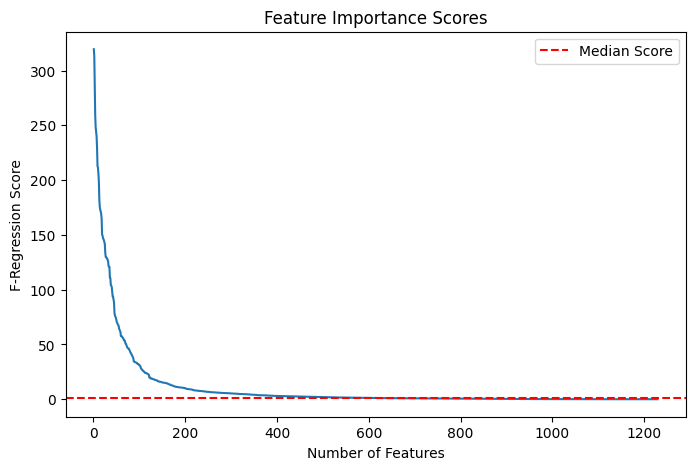

In [86]:
# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# Compute F-scores for all features
selector = SelectKBest(score_func=f_regression, k="all")
X_selected = selector.fit_transform(X_train1, y_train)
scores = selector.scores_

# Sort scores in descending order
sorted_scores = np.sort(scores)[::-1]

# Plot the feature importance scores
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(sorted_scores) + 1), sorted_scores)
plt.xlabel("Number of Features")
plt.ylabel("F-Regression Score")
plt.title("Feature Importance Scores")
plt.axhline(y=np.median(sorted_scores), color="r", linestyle="--", label="Median Score")
plt.legend()
plt.show()


In [140]:
# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# Hyperparameters
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 1]  # Try different L1 values
epochs = 1000
k_values = [100, 150, 200, 250, 300, 350, 400, 450, 500]

# Definening r2 adjusted
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Dictionary of results
results = {}

for k in k_values:
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train1, y_train.ravel())
    X_test_selected = selector.transform(X_test1)

    # Convert to PyTorch tensors
    X_train_tensor1 = torch.tensor(X_train_selected, dtype=torch.float32).to(device)
    X_test_tensor1 = torch.tensor(X_test_selected, dtype=torch.float32).to(device)
    
    # Train and Evaluate for Each Lambda
    for l1_lambda in lambda_values:
        model = LassoRegression(X_train_tensor1.shape[1], l1_lambda=l1_lambda).to(device)
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = torch.nn.MSELoss()

        # Training Loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train_tensor1)
            loss = criterion(y_pred, y_tensor_train) + model.l1_regularization_loss()
            loss.backward()
            optimizer.step()

        # Evaluate on Train & Test Sets
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor1)  # Training set predictions
            y_test_pred = model(X_test_tensor1)   # Test set predictions

        # Convert predictions to NumPy for evaluation
        y_train_pred_numpy = y_train_pred.cpu().numpy().flatten()
        y_test_pred_numpy = y_test_pred.cpu().numpy().flatten()
        y_train_numpy = y_tensor_train.cpu().numpy().flatten()
        y_test_numpy = y_tensor_test.cpu().numpy().flatten()

        # Compute metrics
        mse = mean_squared_error(y_test_numpy, y_test_pred_numpy)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_numpy, y_test_pred_numpy)
        r2_test = r2_score(y_test_numpy, y_test_pred_numpy)  # Test R²
        r2_train = r2_score(y_train_numpy, y_train_pred_numpy)  # Train R²

        # Compute Adjusted R²
        n_train, k = X_train_selected.shape  # n = samples, k = features
        n_test = X_test_selected.shape[0]

        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        # Store results
        results[(k, l1_lambda)] = {
            "MSE": mse, "RMSE": rmse, "MAE": mae, "R2_test": r2_test, "R2_train": r2_train, 
            "Adj_R2_test": adj_r2_test, "Adj_R2_train": adj_r2_train
        }

# Find the best (k, lambda) combination
best_k_lambda = min(results, key=lambda x: (results[x]["MSE"], -results[x]["R2_test"]))  # Minimize MSE, maximize R²
best_mse = results[best_k_lambda]["MSE"]
best_rmse = results[best_k_lambda]["RMSE"]
best_mae = results[best_k_lambda]["MAE"]
best_r2_test = results[best_k_lambda]["R2_test"]
best_r2_train = results[best_k_lambda]["R2_train"]
best_adj_r2_test = results[best_k_lambda]["Adj_R2_test"]
best_adj_r2_train = results[best_k_lambda]["Adj_R2_train"]

# Print optimal hyperparameters and their performance
print(f"✅ Optimal k: {best_k_lambda[0]}, Optimal L1 lambda: {best_k_lambda[1]}")
print(f"📊 Best MSE: {best_mse:.4f}")
print(f"📊 Best RMSE: {best_rmse:.4f}")
print(f"📊 Best MAE: {best_mae:.4f}")
print(f"📊 R² (Train): {best_r2_train:.4f}, Adjusted R² (Train): {best_adj_r2_train:.4f}")
print(f"📊 R² (Test): {best_r2_test:.4f}, Adjusted R² (Test): {best_adj_r2_test:.4f}")


✅ Optimal k: 150, Optimal L1 lambda: 0.001
📊 Best MSE: 1.0363
📊 Best RMSE: 1.0180
📊 Best MAE: 0.6379
📊 R² (Train): 0.1472, Adjusted R² (Train): 0.1376
📊 R² (Test): 0.1751, Adjusted R² (Test): 0.0367


In [134]:
results[(400, 1e-05)]

{'MSE': 6.0510383,
 'RMSE': 2.4598858,
 'MAE': 1.011015,
 'R2_test': -3.8165550231933594,
 'R2_train': 0.14058387279510498,
 'Adj_R2_test': -6.8082041059221545,
 'Adj_R2_train': 0.11439613371672008}

In [133]:
min(results, key=lambda x: (-results[x]["Adj_R2_train"])) 

(400, 1e-05)

In [135]:
# See how many features starting witn 'ac_' have positive and negative coefficients
ac_features = feature_importance[feature_importance["Feature"].str.startswith("ac_")]
positive_ac_features = ac_features[ac_features["Coefficient"] > 0]  
negative_ac_features = ac_features[ac_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'ac_' Features:**"
      f"\nTotal: {len(positive_ac_features)}")
print("\n📊 **Negative 'ac_' Features:**"
      f"\nTotal: {len(negative_ac_features)}")

# See if 'ac_' is mostly positive or negative by adding the values of the 'ac_' coefficients
ac_sum = ac_features["Coefficient"].sum()
if ac_sum > 0:
    print("\n📊 'ac_' features have a positive sum of coefficients.")
elif ac_sum < 0:
    print("\n📊 'ac_' features have a negative sum of coefficients.")
else:
    print("\n📊 'ac_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'ac_' Features:**"
      f"\nTotal: {ac_sum}")


📊 **Positive 'ac_' Features:**
Total: 10

📊 **Negative 'ac_' Features:**
Total: 21

📊 'ac_' features have a negative sum of coefficients.

📊 *Sum 'ac_' Features:**
Total: -0.6685885787010193


In [96]:
# See how many features starting witn 'as_' have positive and negative coefficients
as_features = feature_importance[feature_importance["Feature"].str.startswith("as_")]
positive_as_features = as_features[as_features["Coefficient"] > 0]  
negative_as_features = as_features[as_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'as_' Features:**"
      f"\nTotal: {len(positive_as_features)}")
print("\n📊 **Negative 'as_' Features:**"
      f"\nTotal: {len(negative_as_features)}")

# See if 'as_' is mostly positive or negative by adding the values of the 'as_' coefficients
as_sum = as_features["Coefficient"].sum()
if as_sum > 0:
    print("\n📊 'as_' features have a positive sum of coefficients.")
elif as_sum < 0:
    print("\n📊 'as_' features have a negative sum of coefficients.")
else:
    print("\n📊 'as_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'as_' Features:**"
      f"\nTotal: {as_sum:.4f}")


📊 **Positive 'as_' Features:**
Total: 26

📊 **Negative 'as_' Features:**
Total: 37

📊 'as_' features have a negative sum of coefficients.

📊 *Sum 'as_' Features:**
Total: -0.4549


In [99]:
# See how many features starting witn 'p_' have positive and negative coefficients
p_features = feature_importance[feature_importance["Feature"].str.startswith("p_")]
positive_p_features = p_features[p_features["Coefficient"] > 0]  
negative_p_features = p_features[p_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'p_' Features:**"
      f"\nTotal: {len(positive_p_features)}")
print("\n📊 **Negative 'p_' Features:**"
      f"\nTotal: {len(negative_p_features)}")

# See if 'p_' is mostly positive or negative by adding the values of the 'p_' coefficients
p_sum = p_features["Coefficient"].sum()
if p_sum > 0:
    print("\n📊 'p_' features have a positive sum of coefficients.")
elif p_sum < 0:
    print("\n📊 'p_' features have a negative sum of coefficients.")
else:
    print("\n📊 'p_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'p_' Features:**"
      f"\nTotal: {p_sum:.4f}")


📊 **Positive 'p_' Features:**
Total: 25

📊 **Negative 'p_' Features:**
Total: 34

📊 'p_' features have a negative sum of coefficients.

📊 *Sum 'p_' Features:**
Total: -0.3844


In [100]:
# See how many features starting witn 'r_' have positive and negative coefficients
r_features = feature_importance[feature_importance["Feature"].str.startswith("r_")]
positive_r_features = r_features[r_features["Coefficient"] > 0]  
negative_r_features = r_features[r_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'r_' Features:**"
      f"\nTotal: {len(positive_r_features)}")
print("\n📊 **Negative 'r_' Features:**"
      f"\nTotal: {len(negative_r_features)}")

# See if 'r_' is mostly positive or negative by adding the values of the 'r_' coefficients
r_sum = r_features["Coefficient"].sum()
if r_sum > 0:
    print("\n📊 'r_' features have a positive sum of coefficients.")
elif r_sum < 0:
    print("\n📊 'r_' features have a negative sum of coefficients.")
else:
    print("\n📊 'r_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'r_' Features:**"
      f"\nTotal: {r_sum:.4f}")


📊 **Positive 'r_' Features:**
Total: 45

📊 **Negative 'r_' Features:**
Total: 45

📊 'r_' features have a positive sum of coefficients.

📊 *Sum 'r_' Features:**
Total: 0.2910


In [101]:
# See how many features starting witn 'nuf_' have positive and negative coefficients
nuf_features = feature_importance[feature_importance["Feature"].str.startswith("nuf_")]
positive_nuf_features = nuf_features[nuf_features["Coefficient"] > 0]  
negative_nuf_features = nuf_features[nuf_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'nuf_' Features:**"
      f"\nTotal: {len(positive_nuf_features)}")
print("\n📊 **Negative 'nuf_' Features:**"
      f"\nTotal: {len(negative_nuf_features)}")

# See if 'nuf_' is mostly positive or negative by adding the values of the 'nuf_' coefficients
nuf_sum = nuf_features["Coefficient"].sum()
if nuf_sum > 0:
    print("\n📊 'nuf_' features have a positive sum of coefficients.")
elif nuf_sum < 0:
    print("\n📊 'nuf_' features have a negative sum of coefficients.")
else:
    print("\n📊 'nuf_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'nuf_' Features:**"
      f"\nTotal: {nuf_sum:.4f}")


📊 **Positive 'nuf_' Features:**
Total: 8

📊 **Negative 'nuf_' Features:**
Total: 3

📊 'nuf_' features have a positive sum of coefficients.

📊 *Sum 'nuf_' Features:**
Total: 0.0890


In [102]:
# See how many features starting witn 'vrf_' have positive and negative coefficients
vrf_features = feature_importance[feature_importance["Feature"].str.startswith("vrf_")]
positive_vrf_features = vrf_features[vrf_features["Coefficient"] > 0]  
negative_vrf_features = vrf_features[vrf_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'vrf_' Features:**"
      f"\nTotal: {len(positive_vrf_features)}")
print("\n📊 **Negative 'vrf_' Features:**"
      f"\nTotal: {len(negative_vrf_features)}")

# See if 'vrf_' is mostly positive or negative by adding the values of the 'vrf_' coefficients
vrf_sum = vrf_features["Coefficient"].sum()
if vrf_sum > 0:
    print("\n📊 'vrf_' features have a positive sum of coefficients.")
elif vrf_sum < 0:
    print("\n📊 'vrf_' features have a negative sum of coefficients.")
else:
    print("\n📊 'vrf_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'vrf_' Features:**"
      f"\nTotal: {vrf_sum:.4f}")


📊 **Positive 'vrf_' Features:**
Total: 3

📊 **Negative 'vrf_' Features:**
Total: 5

📊 'vrf_' features have a positive sum of coefficients.

📊 *Sum 'vrf_' Features:**
Total: 0.0101


In [ ]:
# See how many features starting with 'dis' have positive and negative coefficients
dis_features = feature_importance[feature_importance["Feature"].str.startswith("dis")]
positive_dis_features = dis_features[dis_features["Coefficient"] > 0]  
negative_dis_features = dis_features[dis_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'dis' Features:**"
      f"\nTotal: {len(positive_dis_features)}")
print("\n📊 **Negative 'dis' Features:**"
      f"\nTotal: {len(negative_dis_features)}")

# See if 'dis' is mostly positive or negative by adding the values of the 'dis' coefficients
dis_sum = dis_features["Coefficient"].sum()
if dis_sum > 0:
    print("\n📊 'dis' features have a positive sum of coefficients.")
elif vrf_sum < 0:
    print("\n📊 'dis' features have a negative sum of coefficients.")
else:
    print("\n📊 'dis' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'dis' Features:**"
      f"\nTotal: {vrf_sum:.4f}")


📊 **Positive 'dis' Features:**
Total: 2

📊 **Negative 'dis' Features:**
Total: 1

📊 'dis' features have a sum of coefficients equal to zero.

📊 *Sum 'dis' Features:**
Total: 0.0101


In [108]:
# See how many features starting with 'g' have positive and negative coefficients
g_features = feature_importance[feature_importance["Feature"].str.startswith("g")]
positive_g_features = g_features[g_features["Coefficient"] > 0]  
negative_g_features = g_features[g_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'g' Features:**"
      f"\nTotal: {len(positive_g_features)}")
print("\n📊 **Negative 'g' Features:**"
      f"\nTotal: {len(negative_g_features)}")

# See if 'g' is mostly positive or negative by adding the values of the 'g' coefficients
dis_sum = g_features["Coefficient"].sum()
if dis_sum > 0:
    print("\n📊 'g' features have a positive sum of coefficients.")
elif vrf_sum < 0:
    print("\n📊 'g' features have a negative sum of coefficients.")
else:
    print("\n📊 'g' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'g' Features:**"
      f"\nTotal: {vrf_sum:.4f}")


📊 **Positive 'g' Features:**
Total: 2

📊 **Negative 'g' Features:**
Total: 2

📊 'g' features have a sum of coefficients equal to zero.

📊 *Sum 'g' Features:**
Total: 0.0101


In [ ]:
# See how many features ending witn '_total' have positive and negative coefficients
total_features = feature_importance[feature_importance["Feature"].str.endswith("_total")]
positive_total_features = total_features[total_features["Coefficient"] > 0]  
negative_total_features = total_features[total_features["Coefficient"] < 0]

# See the length of positive and negative features
print("\n📊 **Positive 'total_' Features:**"
      f"\nTotal: {len(positive_total_features)}")
print("\n📊 **Negative 'total_' Features:**"
      f"\nTotal: {len(negative_total_features)}")

# See if 'total_' is mostly positive or negative by adding the values of the 'total_' coefficients
total_sum = total_features["Coefficient"].sum()
if total_sum > 0:
    print("\n📊 'total_' features have a positive sum of coefficients.")
elif total_sum < 0:
    print("\n📊 'total_' features have a negative sum of coefficients.")
else:
    print("\n📊 'total_' features have a sum of coefficients equal to zero.")
print("\n📊 *Sum 'total_' Features:**"
      f"\nTotal: {total_sum:.4f}")


📊 **Positive 'total_' Features:**
Total: 2

📊 **Negative 'total_' Features:**
Total: 1

📊 'total_' features have a positive sum of coefficients.

📊 *Sum 'total_' Features:**
Total: 0.0077


### 1.2. Ridge

# New try with panelsplit

In [222]:
import zipfile
import os

# Define file names
csv_filename = "../final_df.csv"
zip_filename = "../final_df.zip"

# Extract the CSV file from the ZIP
with zipfile.ZipFile(zip_filename, 'r') as zipf:
    zipf.extract(csv_filename)

# Read the CSV file into a DataFrame
final_df = pd.read_csv("final_df.csv")

# Delete the extracted CSV file after reading
os.remove("final_df.csv")

In [ ]:
# Data after 2007
final_df = final_df[final_df['year'] > 2006]
# y 
y = final_df['tc_loss']

# Normalize output
scaler = StandardScaler()
y = scaler.fit_transform(y.values.reshape(-1, 1))

# Get rid of columns that start with 'subnational1_' and 'cluster_' in train and test   
#X1 = final_df.loc[:,~final_df.columns.str.startswith('g')]
X1 = final_df.loc[:,~final_df.columns.str.startswith('subnational1_')]
X1 = X1.loc[:,~X1.columns.str.startswith('cluster_')]


# Get rid of all disaggregated columns
X1 = X1.loc[:,~X1.columns.str.startswith('ac_')]
X1 = X1.loc[:,~X1.columns.str.startswith('as_')]
X1 = X1.loc[:,~X1.columns.str.startswith('p_')]
X1 = X1.loc[:,~X1.columns.str.startswith('r_')]
X1 = X1.loc[:,~X1.columns.str.startswith('nuf_')]
X1 = X1.loc[:,~X1.columns.str.startswith('vrf_')]

# X final
X1 = X1.drop(columns=['year','tc_loss', 'tc_loss_area', 'codmpio'])

# Create interaction terms (degree=2 means pairwise interactions)
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_interactions = poly.fit_transform(X1)


# Keep feature names
original_feature_names = list(X1_interactions.columns) 

# Normalize features
X1_interactions = scaler.fit_transform(X1_interactions)



In [322]:
X_interactions

array([[1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [1.00000e+00, 0.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       ...,
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 0.00000e+00,
        0.00000e+00, 0.00000e+00],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 2.55300e+03,
        4.97490e+04, 2.66770e+04],
       [0.00000e+00, 1.00000e+00, 0.00000e+00, ..., 8.05200e+03,
        1.69356e+05, 7.82630e+04]])

In [318]:
len(original_feature_names)

15

In [251]:
from panelsplit.cross_validation import PanelSplit

In [ ]:
# Set seed for reproducibility
seed_value = 17
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)  # If using GPU

# Define TimeSeriesSplit (e.g., 5 splits)
panel_split = PanelSplit(periods = final_df.year, n_splits = 5)

# Hyperparameters
lambda_values = [0.00001, 0.0001, 0.001, 0.01, 0.05, 1]  # Different L1 values
epochs = 1000


# Adjusted R² function
def adjusted_r2(r2, n, k):
    return 1 - (1 - r2) * ((n - 1) / (n - k - 1))

# Dictionary to store results across all CV splits
results = {}

fold_results = []  # Store results for each fold

# Perform TimeSeriesSplit Cross-Validation
for train_idx, test_idx in panel_split.split(X1):
 
    # Split dataset into train & test per fold
    X_train1, X_test1 = X_interactions[train_idx], X_interactions[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Convert to PyTorch tensors
    X_train_tensor1 = torch.tensor(X_train1, dtype=torch.float32).to(device)
    X_test_tensor1 = torch.tensor(X_test1, dtype=torch.float32).to(device)
    y_tensor_train = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_tensor_test = torch.tensor(y_test, dtype=torch.float32).to(device)

    # Train and evaluate for each lambda value
    for l1_lambda in lambda_values:
        model = LassoRegression(X_train_tensor1.shape[1], l1_lambda=l1_lambda).to(device)
        optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.MSELoss()

        # Training Loop
        for epoch in range(epochs):
            optimizer.zero_grad()
            y_pred = model(X_train_tensor1)
            loss = criterion(y_pred, y_tensor_train) + model.l1_regularization_loss()
            loss.backward()
            optimizer.step()

        # Evaluate on train & test sets
        model.eval()
        with torch.no_grad():
            y_train_pred = model(X_train_tensor1)  # Training predictions
            y_test_pred = model(X_test_tensor1)   # Test predictions

        # Convert predictions to NumPy for evaluation
        y_train_pred_numpy = y_train_pred.cpu().numpy().flatten()
        y_test_pred_numpy = y_test_pred.cpu().numpy().flatten()
        y_train_numpy = y_tensor_train.cpu().numpy().flatten()
        y_test_numpy = y_tensor_test.cpu().numpy().flatten()

        # Compute metrics
        mse = mean_squared_error(y_test_numpy, y_test_pred_numpy)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test_numpy, y_test_pred_numpy)
        r2_test = r2_score(y_test_numpy, y_test_pred_numpy)  # Test R²
        r2_train = r2_score(y_train_numpy, y_train_pred_numpy)  # Train R²

        # Compute Adjusted R²
        n_train, k = X_train_selected.shape
        n_test = X_test_selected.shape[0]

        adj_r2_train = adjusted_r2(r2_train, n_train, k)
        adj_r2_test = adjusted_r2(r2_test, n_test, k)

        # Store results for this fold
        fold_results.append({
            "MSE": mse, "RMSE": rmse, "MAE": mae, "R2_test": r2_test, "R2_train": r2_train,
            "Adj_R2_test": adj_r2_test, "Adj_R2_train": adj_r2_train
        })

# Compute average performance across all folds for each (k, lambda)
avg_results = {
    metric: np.mean([fold[metric] for fold in fold_results])
    for metric in fold_results[0].keys()
}
results[(l1_lambda)] = avg_results

# Find the best lambda
best_lambda = min(results, key=lambda x: (results[x]["MSE"], -results[x]["R2_test"]))  # Minimize MSE, maximize R²
best_metrics = results[best_lambda]

# Print optimal hyperparameters and their performance
print(f"🔢 Number of features after Polynomial Features: {X_interactions.shape[1]}")
print(f"✅  Optimal L1 lambda: {best_lambda}")
print(f"📊 Best MSE: {best_metrics['MSE']:.4f}")
print(f"📊 Best RMSE: {best_metrics['RMSE']:.4f}")
print(f"📊 Best MAE: {best_metrics['MAE']:.4f}")
print(f"📊 R² (Train): {best_metrics['R2_train']:.4f}, Adjusted R² (Train): {best_metrics['Adj_R2_train']:.4f}")
print(f"📊 R² (Test): {best_metrics['R2_test']:.4f}, Adjusted R² (Test): {best_metrics['Adj_R2_test']:.4f}")

🔢 Number of features after Polynomial Features: 136
✅  Optimal L1 lambda: 1
📊 Best MSE: 0.5807
📊 Best RMSE: 0.7313
📊 Best MAE: 0.2524
📊 R² (Train): 0.5387, Adjusted R² (Train): 0.5378
📊 R² (Test): 0.4075, Adjusted R² (Test): 0.3823


PermutationExplainer explainer: 16905it [12:44, 22.12it/s]                           
C:\Users\cpedr\AppData\Local\Temp\ipykernel_34544\893074225.py:29: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_train1, feature_names=feature_names)


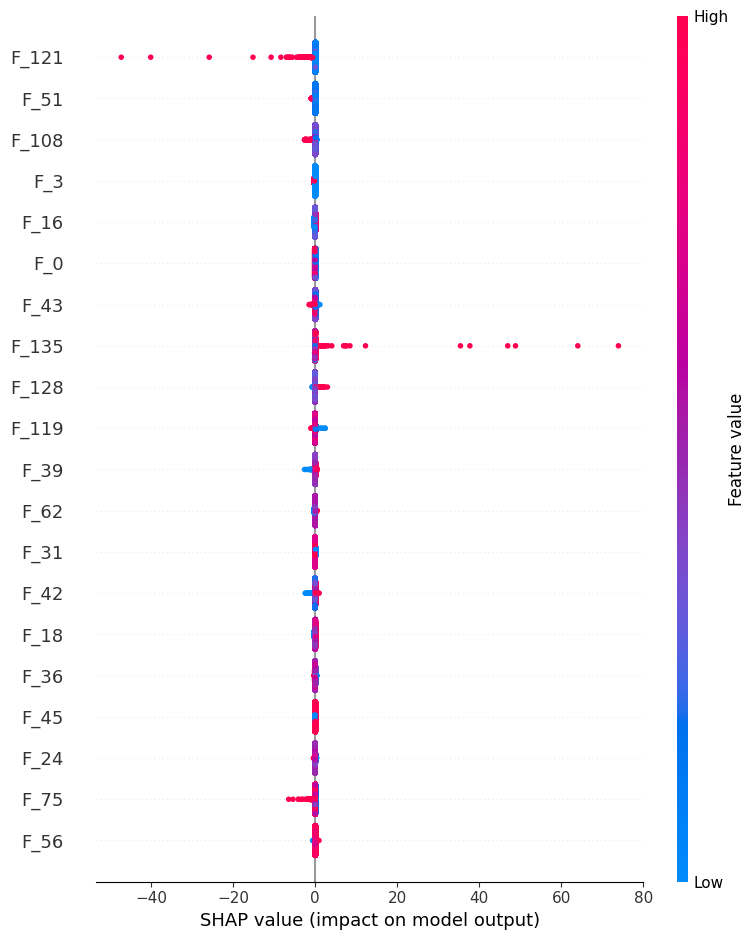

In [ ]:
import shap
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso

# Extract feature names correctly
if isinstance(X1, pd.DataFrame):
    feature_names = poly.get_feature_names_out(input_features=X1.columns)
else:
    feature_names = [f"F_{i}" for i in range(X_interactions.shape[1])]
    
# Ensure Model is on GPU
model = LassoRegression(X_train_tensor1.shape[1], l1_lambda=best_lambda).to(device)

# Define function for SHAP to make predictions
def model_predict(X_numpy):
    X_tensor = torch.tensor(X_numpy, dtype=torch.float32).to(device)  # Convert to PyTorch tensor
    return model(X_tensor).detach().cpu().numpy()  # Get predictions

# Check if it works
test_pred = model_predict(X_train1)  # Try predicting a few samples

# Create SHAP Explainer
explainer = shap.Explainer(model_predict, X_train1)

# Compute SHAP Values
shap_values = explainer(X_train1)

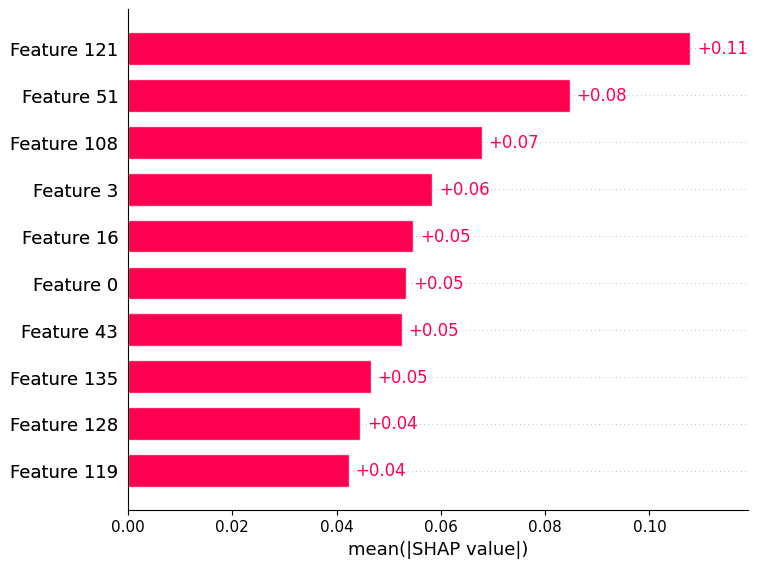

In [ ]:
# Compute mean absolute SHAP values for each feature
shap_abs_mean = np.abs(shap_values.values).mean(axis=0)

# Get indices of the top 10 features
top_10_indices = np.argsort(shap_abs_mean)[-10:]

# Filter SHAP values to keep only the top 10 features
shap_values_top10 = shap.Explanation(
    values=shap_values.values[:, top_10_indices],  # Keep only top 10 values
    base_values=shap_values.base_values,  # Keep base values
    data=shap_values.data[:, top_10_indices],  # Keep only top 10 feature data
    feature_names=[shap_values.feature_names[i] for i in top_10_indices]  # Keep only top 10 feature names
)

# Plot the bar chart without "other features"
shap.plots.bar(shap_values_top10)


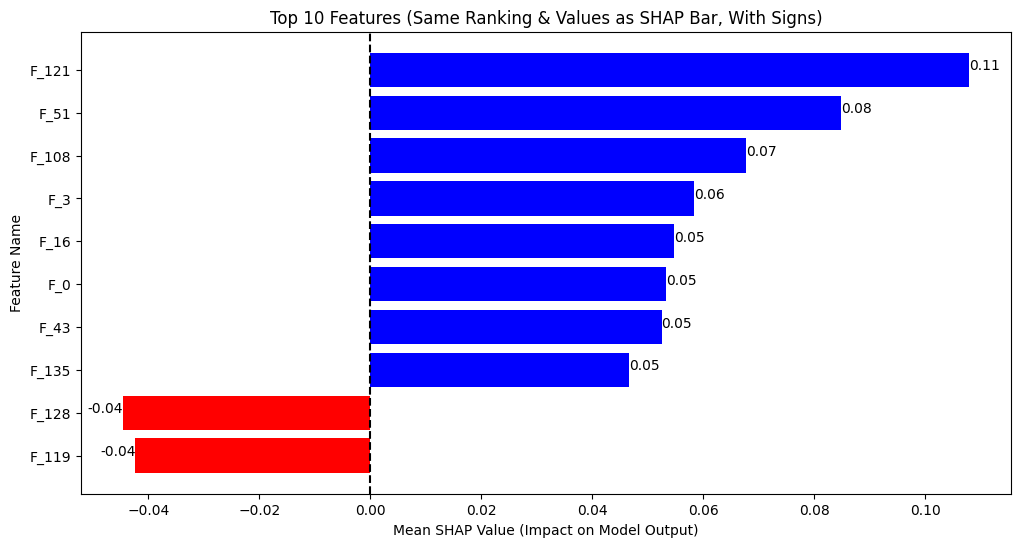

In [ ]:
# Step 1: Compute the mean absolute SHAP values (for correct ranking)
shap_mean_abs = np.abs(shap_values.values).mean(axis=0)  # Matches shap.plots.bar()

# Step 2: Compute the mean SHAP values (to get the correct sign)
shap_mean_signed = shap_values.values.mean(axis=0)

# Step 3: Preserve the ranking from `shap.plots.bar()`, but with correct sign
top_10_indices = np.argsort(shap_mean_abs)[-10:]  # Get indices of top 10 important features
top_10_features = [feature_names[i] for i in top_10_indices]

# Step 4: Preserve absolute values from shap.plots.bar but keep the correct sign
top_10_values_signed = np.sign(shap_mean_signed[top_10_indices]) * shap_mean_abs[top_10_indices]

# Step 5: Plot
plt.figure(figsize=(12, 6))
bars = plt.barh(top_10_features, top_10_values_signed, 
                color=["red" if v < 0 else "blue" for v in top_10_values_signed])

plt.xlabel("Mean SHAP Value (Impact on Model Output)")
plt.ylabel("Feature Name")
plt.title("Top 10 Features (Same Ranking & Values as SHAP Bar, With Signs)")

# Annotate values on bars
for bar, value in zip(bars, top_10_values_signed):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f"{value:.2f}", 
             ha="left" if value > 0 else "right", color="black")

plt.axvline(x=0, color="black", linestyle="--")  # Vertical line at zero for reference
plt.show()
